# Class Activation Mapping with GoogLeNet

In [1]:
#some basic imports and setups
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import io
import os

def grad_cam(img, model, sess, predicted_class, nb_classes):
    print("Setting gradients to 1 for target class and rest to 0")
    # Conv layer tensor [?,7,7,512]
    conv_layer = model.pool5_7x7_s1
    # [1000]-D tensor with target class index set to 1 and rest as 0
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    signal = tf.multiply(model.fc_final, one_hot)
    loss = tf.reduce_mean(signal)

    grads = tf.gradients(loss, conv_layer)[0]
    # Normalizing the gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict={x: img, keep_prob: 1})
    output = output[0]           # [7,7,512]
    grads_val = grads_val[0]     # [7,7,512]

    weights = np.mean(grads_val, axis = (0, 1)) # [512]
    cam = np.ones(output.shape[0 : 2], dtype = np.float32) # [7,7]

    # Taking a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224,224))
    #cam = resize(cam, (224,224))

    # Converting grayscale to 3-D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3

#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'images')

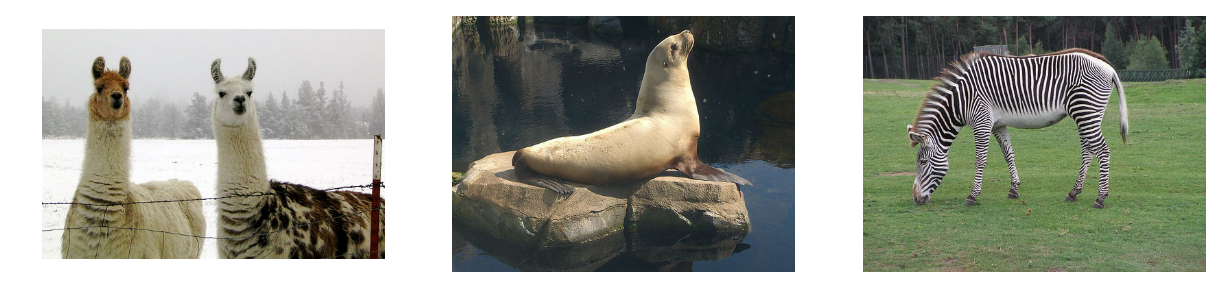

In [2]:
#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpeg')]

#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [3]:
import sys
sys.path.append('./Network')
sys.path.append('./classes')
from googlenet import GoogLeNet
from caffe_classes import class_names

#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 224, 224, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = GoogLeNet(x, keep_prob, 1000, [], './Network/pretrained_model/googlenet.npy', name='GoogLeNet')

#define activation of last layer as score
score = model.fc_final

#create op to calculate softmax 
softmax = tf.nn.softmax(score)

Start to load pre-trained model : 
Load Model: |██████████████████████████████████████████████████| 100.0% Complete
[[[[ 225.34597778  226.72990417  221.96205139]
   [ 223.28794861  224.28794861  221.984375  ]
   [ 223.640625    223.56027222  223.72097778]
   ..., 
   [ 221.          222.          226.        ]
   [ 219.          222.          226.75      ]
   [ 219.          222.          226.75      ]]

  [[ 226.09597778  227.19195557  223.        ]
   [ 224.78794861  225.78794861  223.71205139]
   [ 225.08035278  225.06027222  225.10044861]
   ..., 
   [ 221.          222.          226.        ]
   [ 222.          222.          224.5       ]
   [ 222.          222.          224.5       ]]

  [[ 223.28794861  224.19195557  222.38392639]
   [ 223.          224.          222.        ]
   [ 223.          224.          222.        ]
   ..., 
   [ 221.          222.          226.        ]
   [ 225.          223.          223.        ]
   [ 225.          223.          223.        ]]

  ...

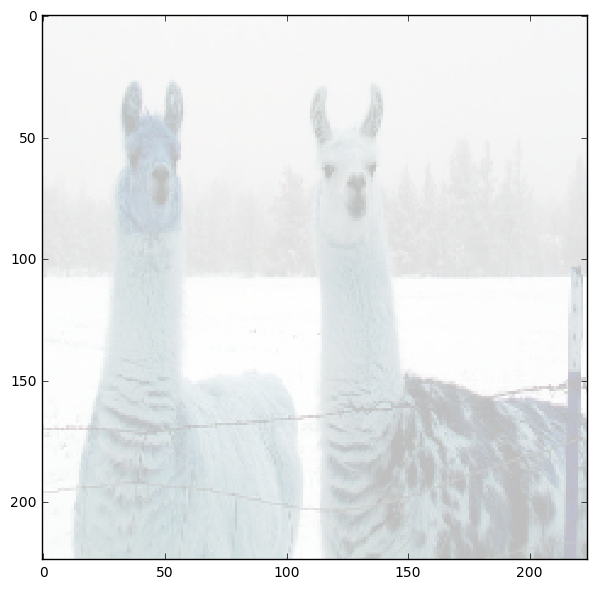

[[[[ 117.54295349  146.98274231  170.67922974]
   [ 125.86283875  155.9811554   174.74659729]
   [ 121.03421783  145.5322876   150.24404907]
   ..., 
   [  33.6043129    31.6043129    21.6043129 ]
   [  37.43767929   36.43767929   26.43767929]
   [  39.38393021   37.38393021   29.3839283 ]]

  [[ 130.20025635  158.43667603  170.81427002]
   [ 109.23599243  135.84312439  148.54455566]
   [  95.42372894  114.79023743  120.36389923]
   ..., 
   [  35.01963043   33.01963043   23.01963043]
   [  39.0111618    38.0111618    28.0111599 ]
   [  40.39509201   38.39509201   30.3950882 ]]

  [[ 119.88600159  147.97589111  151.56486511]
   [ 110.86553192  135.62490845  143.60527039]
   [  94.19208527  109.17275238  115.73525238]
   ..., 
   [  37.38912964   35.38912964   25.38912964]
   [  40.10401535   39.10401535   29.10401344]
   [  41.38393021   39.38393021   31.3839283 ]]

  ..., 
  [[  91.13839722   82.7544632    76.90625   ]
   [  89.25536346   79.40715027   69.55893707]
   [  86.42111969  

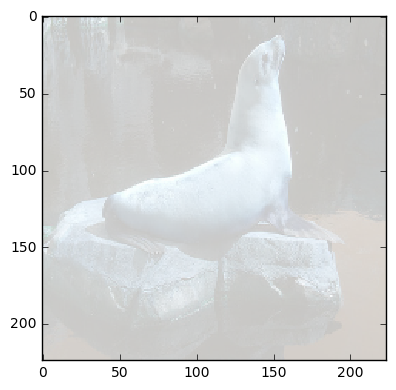

[[[[  41.23431396   40.23431396   36.23431396]
   [  42.41392517   41.41392517   37.41392517]
   [  41.95238876   40.95238876   36.95238876]
   ..., 
   [  28.39939499   29.52276039   23.98287964]
   [  35.40732574   36.84500504   31.96964645]
   [  45.73600769   47.06190109   41.06190109]]

  [[  47.9888382    46.9888382    42.9888382 ]
   [  41.78125      40.78125      36.78125   ]
   [  39.18124008   38.18124008   34.18124008]
   ..., 
   [  29.62322426   27.83260918   26.77457237]
   [  38.359375     37.01454926   33.04803085]
   [  42.65955734   39.63723755   35.67071915]]

  [[  45.99657059   44.99657059   40.99657059]
   [  38.85803986   37.85803986   33.85803986]
   [  38.99926376   37.99926376   33.99926376]
   ..., 
   [  30.46875      27.76114082   28.05058289]
   [  36.76293564   31.07766533   31.44820213]
   [  41.77248001   36.08721161   36.45774841]]

  ..., 
  [[  94.65908051  132.00863647  125.62083435]
   [  87.43437195  123.27186584  113.57543182]
   [  89.88693237  

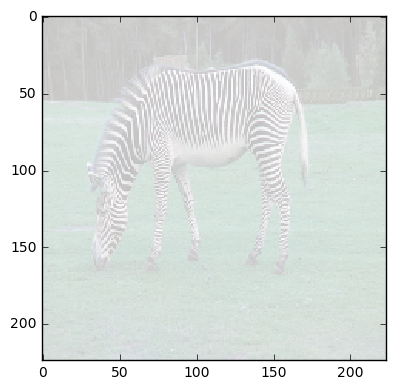

In [4]:
writer = tf.summary.FileWriter('./summary/googlenet')
with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Summary write
    writer.add_graph(sess.graph)
    
    # Loop over all images
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (224,224))
        
        # Subtract the ImageNet mean
        #img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,224,224,3))
        img_forflot = img.reshape((224,224,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        print(img)
        
        # Feed forwarding
        #preds_list = (np.argsort(probs)[::-1])[0:5]
        preds_list = (np.argsort(probs).flatten()[::-1])[0:5]
        print('\nTop 5 classes are')        
        for p in preds_list:
            print(class_names[p], probs[0, p])
        
        # Target class
        predicted_class = preds_list[0]
        # Target layer for visualization
        layer_name = 'pool5_7x7_s1'
        # Number of output classes of model being used
        nb_classes = 1000
        
        cam3 = grad_cam(img, model, sess, predicted_class, nb_classes)
        
        img_float = img_forflot.astype(float)
        img_float /= img_float.max()
        
        #print(img) 

        # Superimposing the visualization with the image.
        new_img = img_float+3*cam3
        new_img /= new_img.max()
        
        #print(new_img)        
        
        #img = img.reshape((224, 244, 3))
        
        # Plot image with class name and prob in the title
        #fig2.add_subplot(1,3,i+1)
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        #plt.axis('off')
        
        # Display and save
        io.imshow(new_img)
        plt.show()
        #io.imsave('output', new_img)